## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [2]:
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'


With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia,sheet='Food Expenditures (2011-12)')
x['i'] = x['i'].astype(str)
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia,sheet='Food Prices (2011-12)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(Ethiopia,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.



### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [21]:
from cfe import Regression
import cfe
result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [22]:
result.predicted_expenditures()

i              t        m       j        
1010101601002  2011-12  Tigray  Banana        11.652049
                                Chat/Kat     108.598175
                                Coffee        33.892525
                                Eggs          13.791468
                                Field Pea     23.083281
                                                ...    
7210106202195  2011-12  SNNP    Salt           3.421438
                                Sorghum       30.428765
                                Sugar         18.850554
                                Teff          79.497424
                                Wheat         43.932792
Length: 47055, dtype: float64

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

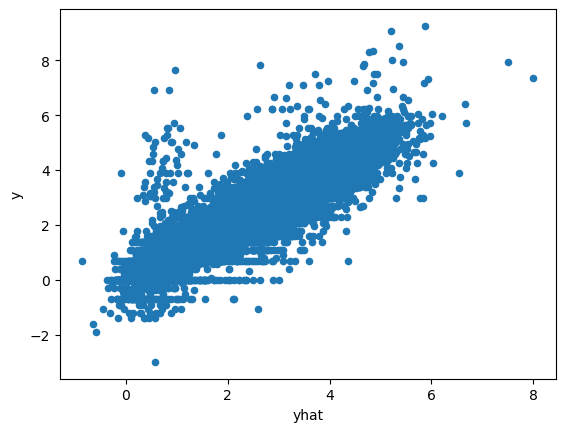

In [23]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



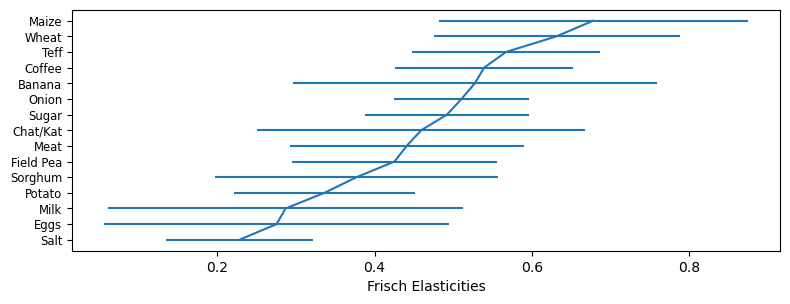

In [24]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [25]:
result.get_beta()

j
Banana       0.527397
Chat/Kat     0.459318
Coffee       0.539258
Eggs         0.275389
Field Pea    0.425250
Maize        0.677973
Meat         0.440854
Milk         0.286823
Onion        0.510546
Potato       0.336244
Salt         0.228052
Sorghum      0.377076
Sugar        0.492017
Teff         0.567075
Wheat        0.631319
Name: beta, dtype: float64

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [26]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,0.0,-0.187668,-0.100071,0.090233,0.056032,-0.008031,0.031665,0.000000e+00,-0.031110,-0.084917,0.128403,-0.014851,0.256981,-0.058693,0.153501,1.660771
Chat/Kat,0.0,0.114105,0.223379,0.171073,0.230958,-0.037930,-0.013608,1.387779e-16,0.131043,-0.038674,-0.005534,0.208971,0.218307,0.171386,-0.208233,4.065754
Coffee,0.0,-0.095061,0.030181,0.067874,0.091498,0.043649,-0.030338,-1.040834e-17,0.030059,-0.024694,0.056096,-0.044672,0.112013,0.128804,0.100772,3.010327
Eggs,0.0,-0.135197,0.051003,-0.108898,-0.162369,-0.385708,-0.031202,-2.636780e-16,-0.229090,-0.154319,-0.035864,-0.046280,-0.043725,0.314028,0.456668,2.597646
Field Pea,0.0,-0.027090,0.065446,0.128661,0.063450,0.092961,0.029228,-3.469447e-17,0.033676,-0.001475,0.037698,0.015677,0.138646,0.091073,0.105354,2.616577
Maize,0.0,0.040513,-0.108505,-0.040537,0.047248,0.034737,-0.117032,1.110223e-16,0.052307,0.020724,0.067978,0.125592,0.106950,0.052652,0.517483,3.283636
Meat,0.0,0.015928,-0.063100,-0.000436,0.219935,0.146714,0.053513,-9.714451e-17,-0.047305,-0.019730,-0.045161,0.085102,0.081780,0.141392,0.255197,4.123313
Milk,0.0,0.109656,-0.281795,0.174924,0.037198,0.065459,-0.191205,-1.734723e-16,0.159276,-0.074930,0.164176,-0.133215,0.020331,0.327841,0.124497,3.022665
Onion,0.0,-0.011914,-0.005323,0.123480,0.145716,-0.050792,-0.140016,1.387779e-17,-0.020367,-0.006574,0.126977,0.050706,0.087002,0.080192,0.048994,2.063841


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

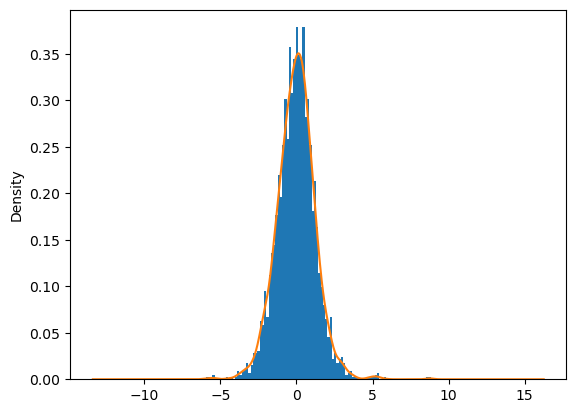

In [27]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [28]:
result.to_pickle('ethiopia_estimates.rgsn')

You can subsequently load this using



In [29]:
import cfe
result = cfe.regression.read_pickle('ethiopia_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [30]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [31]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [32]:
p

t                 2011-12                                          \
m                    Afar     Amhara Benishangul-Gumuz  Dire Dawa   
j                                                                   
Banana          12.719136   8.727964          5.161032   9.480260   
Barley          12.500000   6.816409         14.000000  10.899999   
Chat/Kat       200.300826  48.792931         58.270776  38.066455   
Cheese                NaN        NaN               NaN        NaN   
Chick Pea       18.666666  14.614968         22.119047        NaN   
Coffee         106.107681  84.961716         68.954637  53.509090   
Eggs            17.107583  12.282080         12.698412  10.611111   
Field Pea       20.500000  17.795617         23.159999  26.359042   
Haricot Beans    7.800000  52.243167          9.526735   7.192043   
Horsebeans      22.625000  26.436745         16.520000  25.930735   
Kocho           50.000000  48.222222          2.500000        NaN   
Lentils         24.511628  21.058427         26.777777        NaN   
Linseed         19.999999  15.910113         12.000000  24.632600   
Maize            6.686601   5.719978          3.247090   8.144729   
Meat            65.267855  78.042404         51.425925  68.999997   
Milk            21.666667  62.430387          8.000000   8.006961   
Millet                NaN   5.785660          3.965079        NaN   
Niger Seed      19.090908  17.481493         10.111111        NaN   
Onion           40.838612  19.367401         11.826316  29.642179   
Potato           9.138889   7.611918          6.975000  40.999018   
Salt            14.234374  16.553893          6.967848   7.988564   
Sorghum          4.166667   7.381789          4.777098   6.150021   
Sugar           26.939247  31.275645         23.457371  41.600118   
Teff            14.975168  10.045251         13.066667   7.936508   
Wheat            8.176963   9.068002          9.090909  10.338104   

t                                                                         \
m                  Gambela     Harari     Oromia        SNNP      Somali   
j                                                                          
Banana            5.536467  10.999177   9.155665    9.525529   12.995237   
Barley           84.569441  16.000000  10.362240    8.966185         NaN   
Chat/Kat        100.714281  54.562239  37.708219   34.495670  101.292567   
Cheese           22.105262        NaN  16.855615   34.156627         NaN   
Chick Pea        17.000000  15.500000  10.876531   16.065072   15.999999   
Coffee           75.586732  87.107496  89.963092  122.103984   83.568771   
Eggs             11.885185  15.740740  11.675299   12.843198  133.950612   
Field Pea        21.681321  17.599999  15.891058   14.062776   12.500000   
Haricot Beans    37.864284   8.000000  41.041857   19.990899   13.383041   
Horsebeans       18.443898        NaN  17.848327   51.896768   10.000000   
Kocho             9.856163        NaN  11.676176   47.489012   54.999997   
Lentils          24.538461  27.999999  23.919585   24.472048   27.999999   
Linseed                NaN  22.194265  17.105605   26.018517         NaN   
Maize           235.678263   8.466369   5.023135    9.094639    8.657109   
Meat             72.983739  70.249998  72.074998   54.632867   60.190475   
Milk           1630.036932  10.649753  11.236582    5.767124   11.448404   
Millet                 NaN        NaN   6.504168    6.000000         NaN   
Niger Seed             NaN        NaN  13.399999   31.999998         NaN   
Onion            11.302564   9.729745  16.507272   14.302836   53.551389   
Potato            8.733333   6.103297  23.903467    7.243993   19.578453   
Salt              8.688395  16.283892  10.600245   27.640815    9.771768   
Sorghum         109.709972  12.184286   6.056871    4.439311    7.307391   
Sugar            21.606462  19.882205  24.995582   21.073666   55.160936   
Teff             12.349107  10.400000  16.748875   17.629946   37.821013   
Wheat          

Text(0.5, 0, 'Quantities of Teff Demanded')

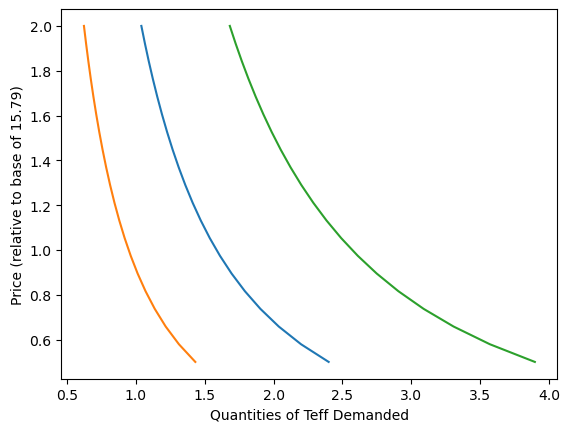

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Teff'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



Text(0.5, 1.0, 'Engel Curves')

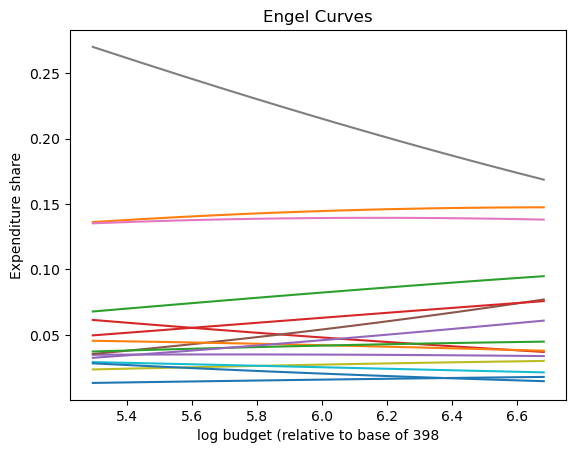

In [34]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



In [ ]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')